In [204]:
# bibliotecas de análise e manipulação
import pandas as pd 
import numpy as np
import matplotlib
import seaborn as sns
import yfinance as yf
import requests
import pmdarima
import matplotlib.pyplot as plt
from matplotlib import ticker
import xgboost as xgb
 
# visualização gráfica
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsforecast import StatsForecast

# bibliotecas de previsão
from xgboost import XGBClassifier # --> Modelo de ML XGBoost
from statsmodels.tsa.api import ExponentialSmoothing
from pmdarima import auto_arima

# testes estatisticos
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

puxamos os dados do Ibovespa usando o yfinance.
explicar pq pegamos os dados de 1995 até o periodo atual.

In [9]:
dados_yf = []
dados_yf = yf.download('^BVSP', period="max", interval="1d", auto_adjust=True,  progress=False, multi_level_index=False)
dados_yf = pd.DataFrame(dados_yf.loc['2015-01-01':'2025-08-01'])

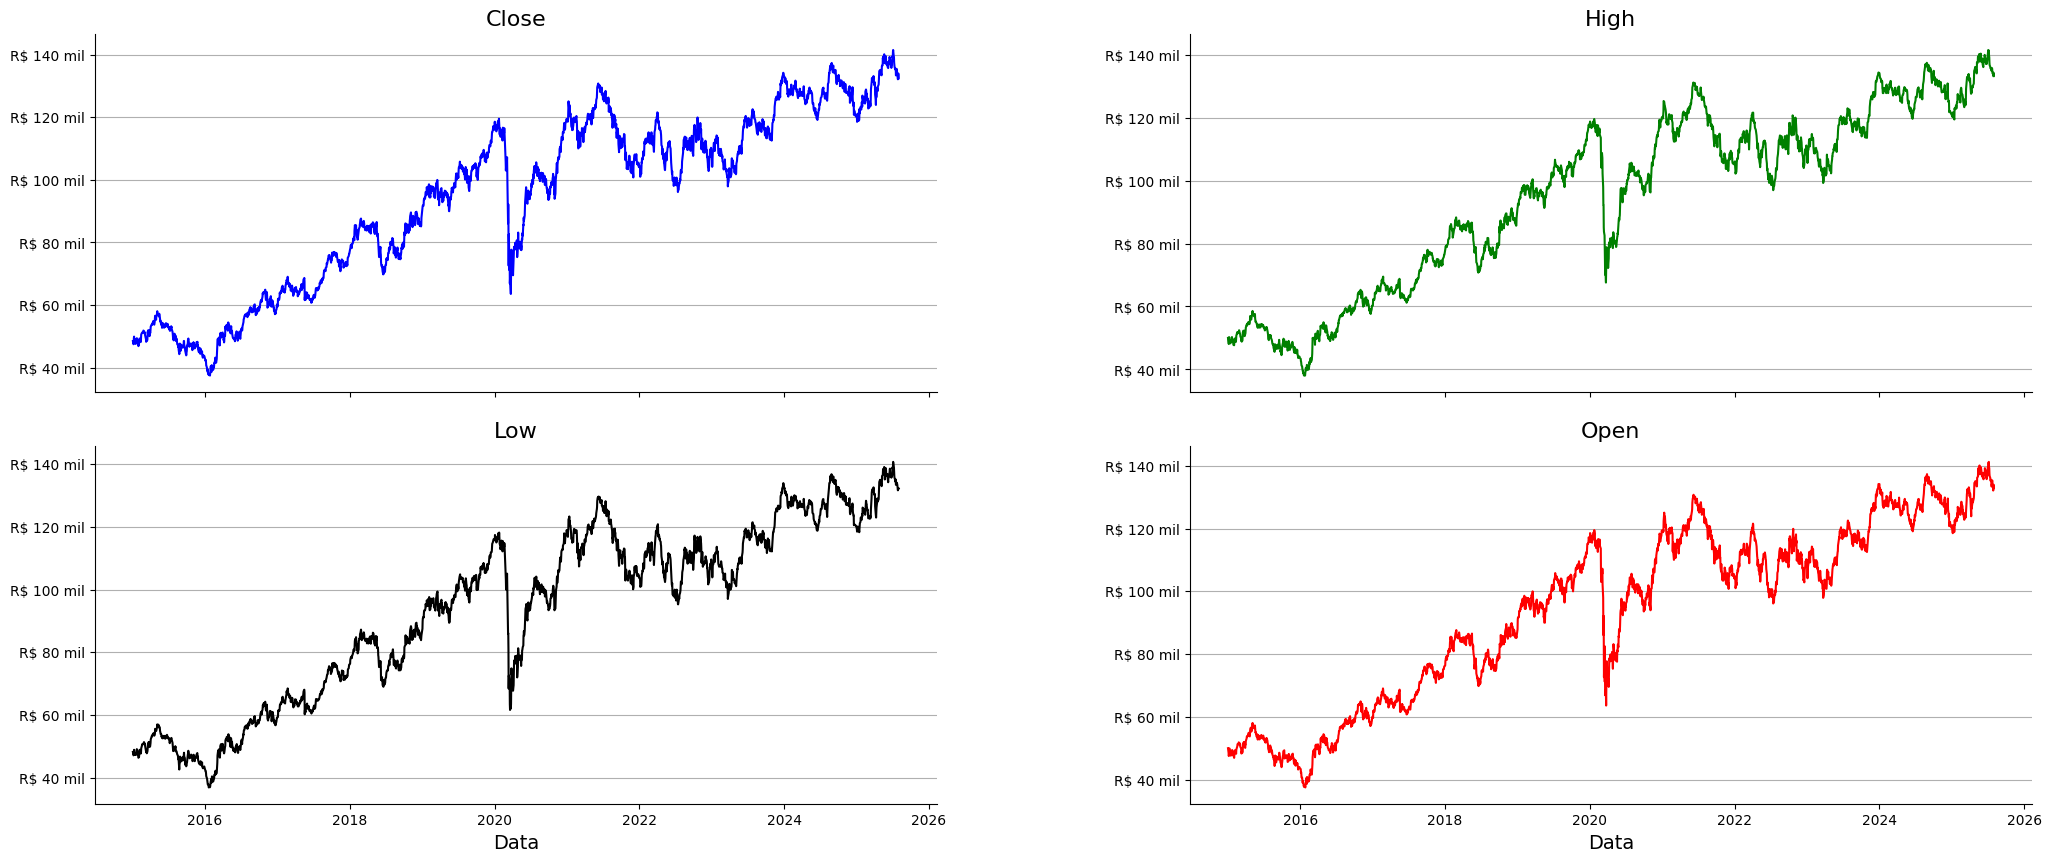

In [3]:
# visualização
def formatar_unidade(x, pos):
    return f'R$ {x/1000:.0f} mil'
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(25,10))
formatter = ticker.FuncFormatter(formatar_unidade)
# último
sns.lineplot(x=dados_yf.index,
            y=dados_yf['Close'],
             color='blue',
            ax=ax1)
# máxima
sns.lineplot(x=dados_yf.index,
            y=dados_yf['High'],
             color='green',
            ax=ax2)
# mínima
sns.lineplot(x=dados_yf.index,
            y=dados_yf['Low'],
             color='black',
            ax=ax3)
# abertura
sns.lineplot(x=dados_yf.index,
            y=dados_yf['Open'],
             color='red',
            ax=ax4)
sns.despine(right=True, top=True)
# Ajustar os títulos dos eixos e o espaçamento
plt.subplots_adjust(hspace=0.15, wspace=0.3)
for i in (ax1, ax2, ax3, ax4):
  i.grid(axis='y')

# Iterando as colunas nos títulos
for i, ax in zip(dados_yf.iloc[:, :4].columns, (ax1, ax2, ax3, ax4)):
    ax.set_title(i, fontsize=16)
# looping para setar o tamanho do x e tirar os y labels
for i in (ax1,ax2,ax3,ax4):
  i.set_xlabel('Data', fontsize=14)
  i.set_ylabel('')
  i.yaxis.set_major_formatter(formatter)
plt.show()

Explicar as séries temporais, junto da decomposiÇão realizada a seguir. pontos interessantes a falar: a série tem uma sazonalidade bem clara e aparente no ano de 2021, indicando quebra estrutural e necessidade de análise especializada neste período.

<Figure size 2000x1000 with 0 Axes>

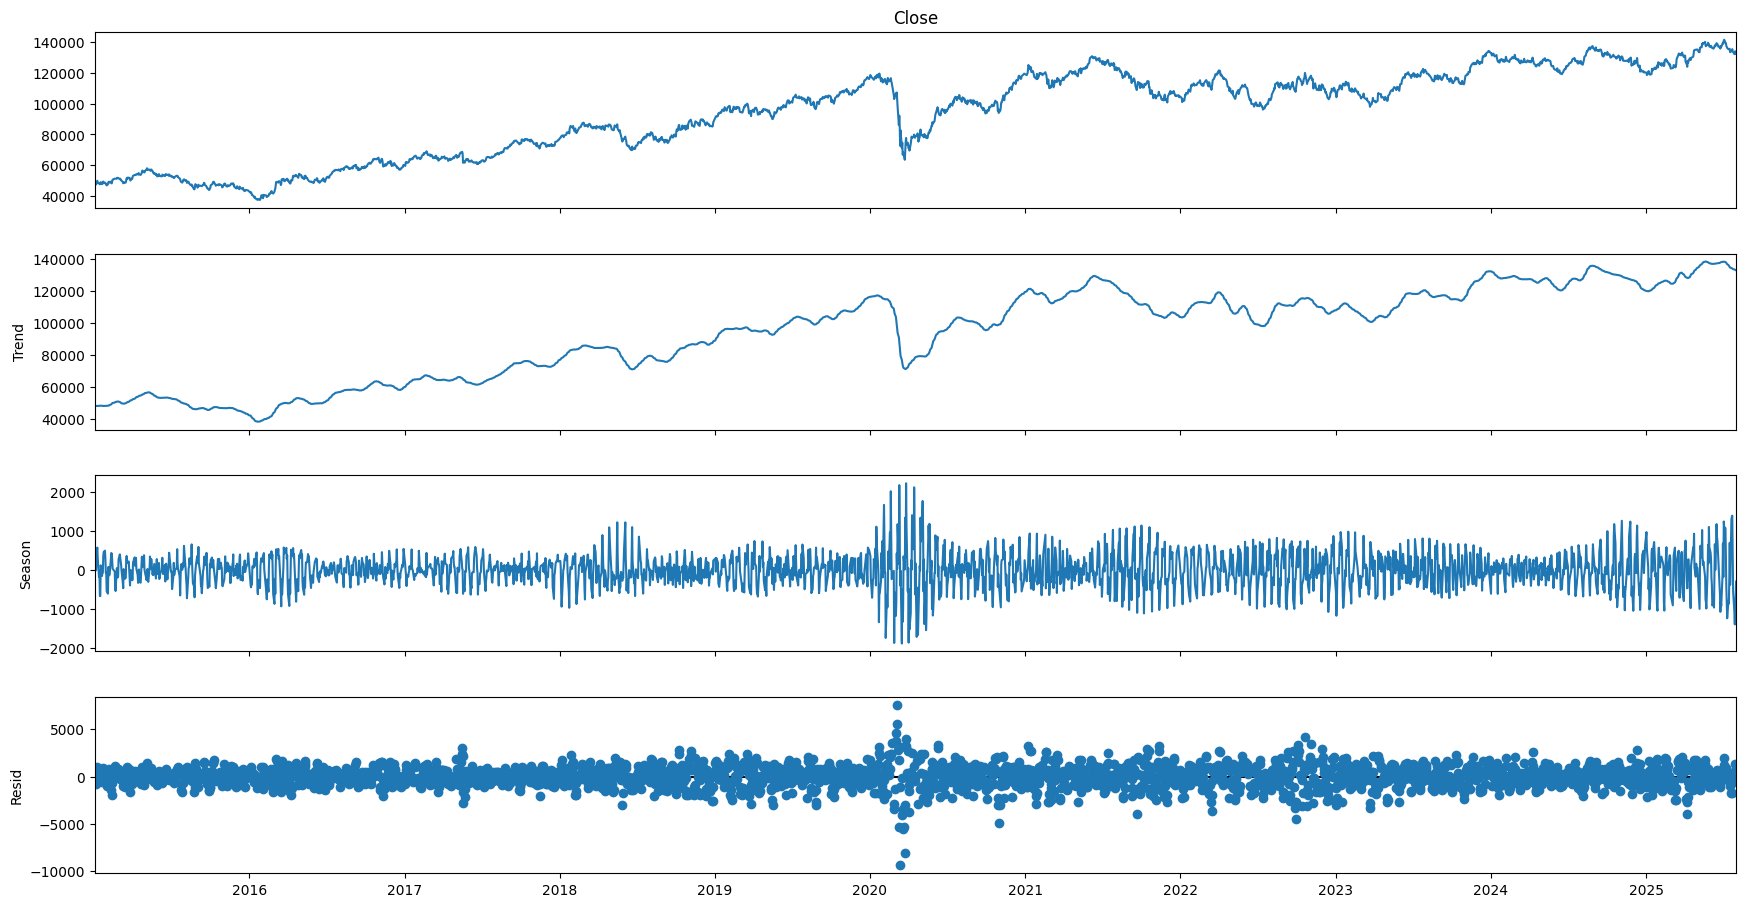

In [ ]:
stl = STL(dados_yf['Close'], period=12, seasonal=13)
res = stl.fit()
fig = plt.figure(figsize=(20, 10))
res.plot().set_size_inches(20, 10)
plt.show()

Teste de Dickey-Fuller, ou teste de raiz unitária:

O teste é realizado para observar a presença de raiz unitária na série temporal, de forma a predizer o quão fortemente esta é afetada pela tendência.

Para interpretar o resultado do teste, precisamos inicialmente realizar um teste de hipótese com o p-valor para:

Aceitar (ou falhar em rejeitar) a Hipótese Nula (H0), sugerindo a presença de uma raiz unitária na série, e consequentemente sendo uma série não-estacionária;
Rejeitada a Hipótese Nula (H0), aceitamos a Hipótese Alternativa (H1) que sugere a não-presença de raiz unitária na série, indicando-a como série estacionária.
Para tal, observamos o p-valor e comparamos com o nível de significância esperado ao modelo. Desta forma:

Se o p-valor for maior que o nível de significância, aceitamos (ou falhamos em rejeitar) a hipótese nula (H0), e a série apresenta raiz unitária/é não-estacionária;
Se o p-valor for menor ou igual que o nível de significância, aceitamos a hipótese alternativa (H1), e a série não apresenta raiz unitária/é estacionária.

OU

p-valor > 0.05 -> série não-estacionária;
p-valor <= 0.05 -> série estacionária.

---

No teste de Dickey Fuller Aumentado, a hipótese nula é de que a série contém raiz unitária, e a alternativa é de que a série é estacionária.
se eu rejeito a nula (abaixo de 5%), a série é estacionária;
se eu falho em rejeitar (acima de 5%), a série tem raiz unitária.

No teste de KPSS, a hipótese nula é que a série é estacionária, e a alternativa de que a série tem raiz unitária.
se eu rejeito a nula, a série tem raiz unitária;
se eu falho em rejeitar a nula, a série é estacionária.

O teste de Phillips-Perron funciona similarmente ao teste de Dickey-Fuller, contudo sua análise difere ao não incluir as defasagens ao rodar a regressão. Nele:
se eu rejeito a nula, a série é estacionária;
se eu falho em rejeitar, a série tem raiz unitária.

Os valores apresentados por ambos os testes apontam que a série não é estacionária, uma vez que:
O teste de Dickey Fuller Aumentado apresenta p-valor acima de 1%, 5% e 10%, falhando em rejeitar a hipótese nula de que a série contém raiz unitária, determinando que a série não é estacionária;
O teste de KPSS apresenta p-valor abaixo de 1%, rejeitando a hipótese nula de que a série é estacionária;
O teste de Phillips-Perron apresentou p-valor acima de 5%, falhando em rejeitar a hipótese nula de que a série contém raiz unitária.

In [ ]:
teste_adf = adfuller(dados_yf['Close'], regression = 'c')
print('Estatística ADF - Constante: %f' %teste_adf[0])
print('p-valor: %f' %teste_adf[1])
print('=-----------------------------------=')
teste_kpss = kpss(dados_yf['Close'])
print('Estatística KPSS: %f' %teste_kpss[0])
print('p-valor: %f' %teste_kpss[1])
print('=-----------------------------------=')
teste_pp = PhillipsPerron(dados_yf['Close'])
print(teste_pp.summary().as_text())

Estatística ADF - Constante: -1.433127
p-valor: 0.566296
=-----------------------------------=
Estatística KPSS: 7.659354
p-valor: 0.010000
=-----------------------------------=
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.423
P-value                         0.571
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\cayou\AppData\Local\Temp\ipykernel_26048\3622192582.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  teste_kpss = kpss(dados_yf['Close'])


explicar como a não-estacionaridade da série implica na análise. É visível observar tanto pelos testes anteriores quanto pela análise gráfica a do ACF da série de fechamento.

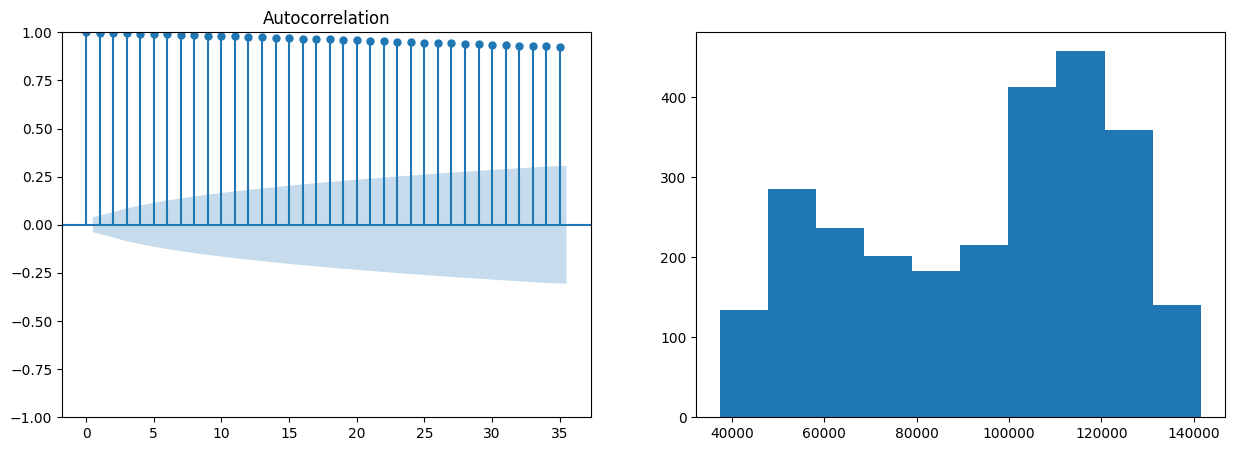

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
plot_acf(dados_yf['Close'], ax = ax1)
plt.hist(dados_yf['Close'])
plt.show()

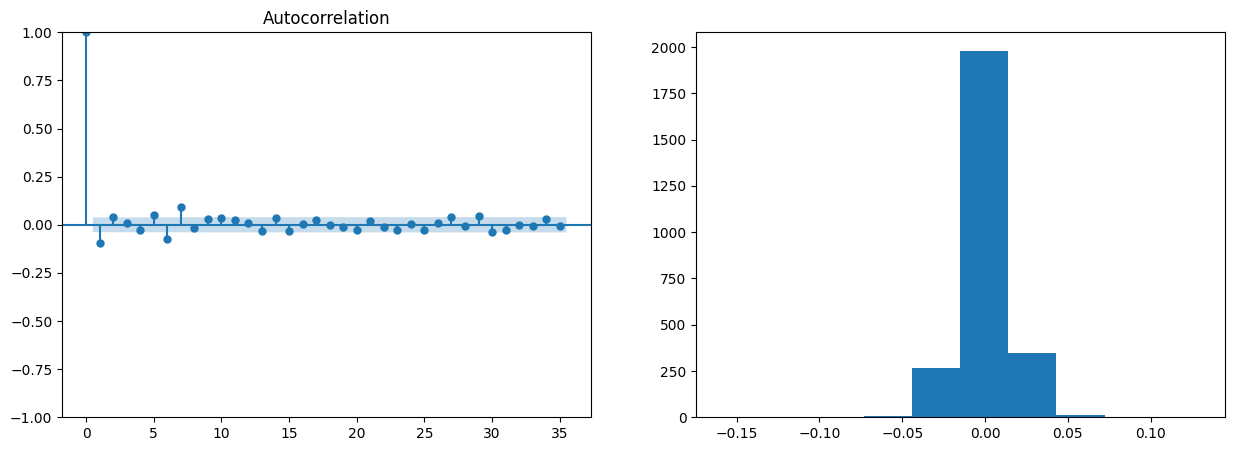

In [ ]:
df_estacionaria = np.log(dados_yf['Close']).diff().dropna()

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
plot_acf(df_estacionaria, ax = ax1)
plt.hist(df_estacionaria)
plt.show()

In [ ]:
teste_adf = adfuller(df_estacionaria, regression = 'c')
print('Estatística ADF - Constante: %f' %teste_adf[0])
print('p-valor: %f' %teste_adf[1])
print('=-----------------------------------=')
teste_kpss = kpss(df_estacionaria)
print('Estatística KPSS: %f' %teste_kpss[0])
print('p-valor: %f' %teste_kpss[1])
print('=-----------------------------------=')
teste_pp = PhillipsPerron(df_estacionaria)
print(teste_pp.summary().as_text())

Estatística ADF - Constante: -18.381747
p-valor: 0.000000
=-----------------------------------=
Estatística KPSS: 0.058114
p-valor: 0.100000
=-----------------------------------=
     Phillips-Perron Test (Z-tau)    
Test Statistic                -56.143
P-value                         0.000
Lags                               28
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


C:\Users\cayou\AppData\Local\Temp\ipykernel_26048\3744172140.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  teste_kpss = kpss(df_estacionaria)


## DELIMITAÇÃO DE PERÍODO DE TREINO E PERÍODO DE TESTE

In [193]:
df_treino = dados_yf['Close'].loc['2015-01-01':'2025-06-30']
df_teste = dados_yf['Close'].loc['2025-07-01':'2025-08-01']

df_treino_80 = dados_yf['Close'].loc['2015-01-01':'2023-06-27']
df_teste_80 = dados_yf['Close'].loc['2023-06-28':'2025-08-01']

dados_yf['Target'] = (dados_yf['Close'].shift(-1) > dados_yf['Close']).astype(int)

x = dados_yf.drop('Target', axis=1)
x_treino = dados_yf.drop('Target', axis=1).loc['2015-01-01':'2023-06-27']
x_teste = dados_yf.drop('Target', axis=1).loc['2023-06-28':'2025-08-01']

y = dados_yf['Target']
y_treino = dados_yf['Target'].copy().loc['2015-01-01':'2023-06-27']
y_teste =dados_yf['Target'].copy().loc['2023-06-28':'2025-08-01']

In [194]:
scaler = StandardScaler()
scaler.fit(x_treino)

x_treino_scaled = scaler.transform(x_treino)
x_teste_scaled = scaler.transform(x_teste)

In [124]:
dados_yf

,Close,High,Low,Open,Volume,Target
Date,,,,,,
2015-01-02,48512.0,50005.0,48345.0,50005.0,2882100,0
2015-01-05,47517.0,48512.0,47264.0,48512.0,3866100,1
2015-01-06,48001.0,48061.0,47338.0,47517.0,4559300,1
2015-01-07,49463.0,49882.0,48006.0,48006.0,4408800,1
2015-01-08,49943.0,50261.0,49017.0,49463.0,3621900,0
...,...,...,...,...,...,...
2025-07-28,132129.0,133902.0,131550.0,133538.0,6625600,1
2025-07-29,132726.0,133346.0,132130.0,132130.0,6324800,1
2025-07-30,133990.0,134368.0,131883.0,132702.0,8655300,0


Lembrete: para os modelos que consideram a sazonalidade em si, vamos rodar primeiro com seasonal_periods = 10, com base na inferencia que a sazonalidade se repete a cada ano. contudo, podemos tentar rodar com sp = n_de_meses caso seja interessante observar a reincidencia sazonal a cada mês.

Com base nos dados fornecidos, que representam o componente sazonal diário do Ibovespa após decomposição da série histórica, sugiro a utilização de um padrão sazonal semanal (5 dias úteis) como o componente mais adequado.

Justificativa:
Natureza dos dados financeiros:

O Ibovespa opera apenas em dias úteis (segunda a sexta-feira), excluindo finais de semana e feriados.

A sazonalidade mais relevante em séries financeiras diárias costuma ser de curto prazo, com padrões que se repetem a cada semana de negociação.

## PREVISÃO COM ARIMA E SARIMA


### ARIMA

In [69]:
model_arima = auto_arima(df_treino, 
                         start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         d=None,
                         seasonal=False,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(model_arima.summary())

forecast_arima = model_arima.predict(n_periods=24)
forecast_arima.index = df_teste.index

print('MAPE:', round(MAPE(df_teste, forecast_arima)*100,2),"%")
print('wMAPE:', round(MAPE(df_teste, forecast_arima,sample_weight=df_teste)*100,2),"%")
print('MSE:', round(MSE(df_teste, forecast_arima),2))

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finit

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=44723.026, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44738.723, Time=0.06 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44721.729, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44722.640, Time=0.20 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44738.529, Time=0.06 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=44722.442, Time=0.26 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=44723.845, Time=1.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=44721.937, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.538 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2601
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -22357.865
Date:                dom, 03 ago 2025   AIC                          44721.729
Time:                        18:57:20   BIC                          44739.319
Sample:                             0   HQIC                         44728.102
                               - 2601                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [68]:
model_arima_80 = auto_arima(df_treino_80, 
                         start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         d=None,
                         seasonal=False,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(model_arima_80.summary())

forecast_arima_80 = model_arima.predict(n_periods=524)
forecast_arima_80.index = df_teste_80.index

print('MAPE:', round(MAPE(df_teste_80, forecast_arima_80)*100,2),"%")
print('wMAPE:', round(MAPE(df_teste_80, forecast_arima_80, sample_weight=df_teste_80)*100,2),"%")
print('MSE:', round(MSE(df_teste_80, forecast_arima_80),2))

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finit

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=36243.762, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36259.282, Time=0.05 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36242.810, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36243.952, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36258.513, Time=0.04 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36242.844, Time=0.20 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=36244.024, Time=1.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=36242.372, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=36242.287, Time=0.11 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0]             : AIC=36241.903, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=36243.609, Time=0.16 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=36236.599, Time=0.71 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=36240.462, Time=0.36 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=36245.640, Time=0.29 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=36234.425, Time=1.31 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=36245.406, Time=0.18 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=36238.295, Time=1.35 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=36233.873, Time=2.71 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=36234.391, Time=1.77 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=36242.397, Time=1.56 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=36234.512, Time=1.71 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=36241.571, Time=0.61 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=36236.186, Time=1.71 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=36236.341, Time=3.28 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0]          
Total fit time: 20.371 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2101
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -18109.936
Date:                dom, 03 ago 2025   AIC                          36233.873
Time:                        18:56:58   BIC                          36273.421
Sample:                             0   HQIC                         36248.358
                               - 2101                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5878      0.099     -5.925      0.000      -0.78

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: title={'center': 'Previsão com treino 80:20'}, xlabel=' ', ylabel=' '>

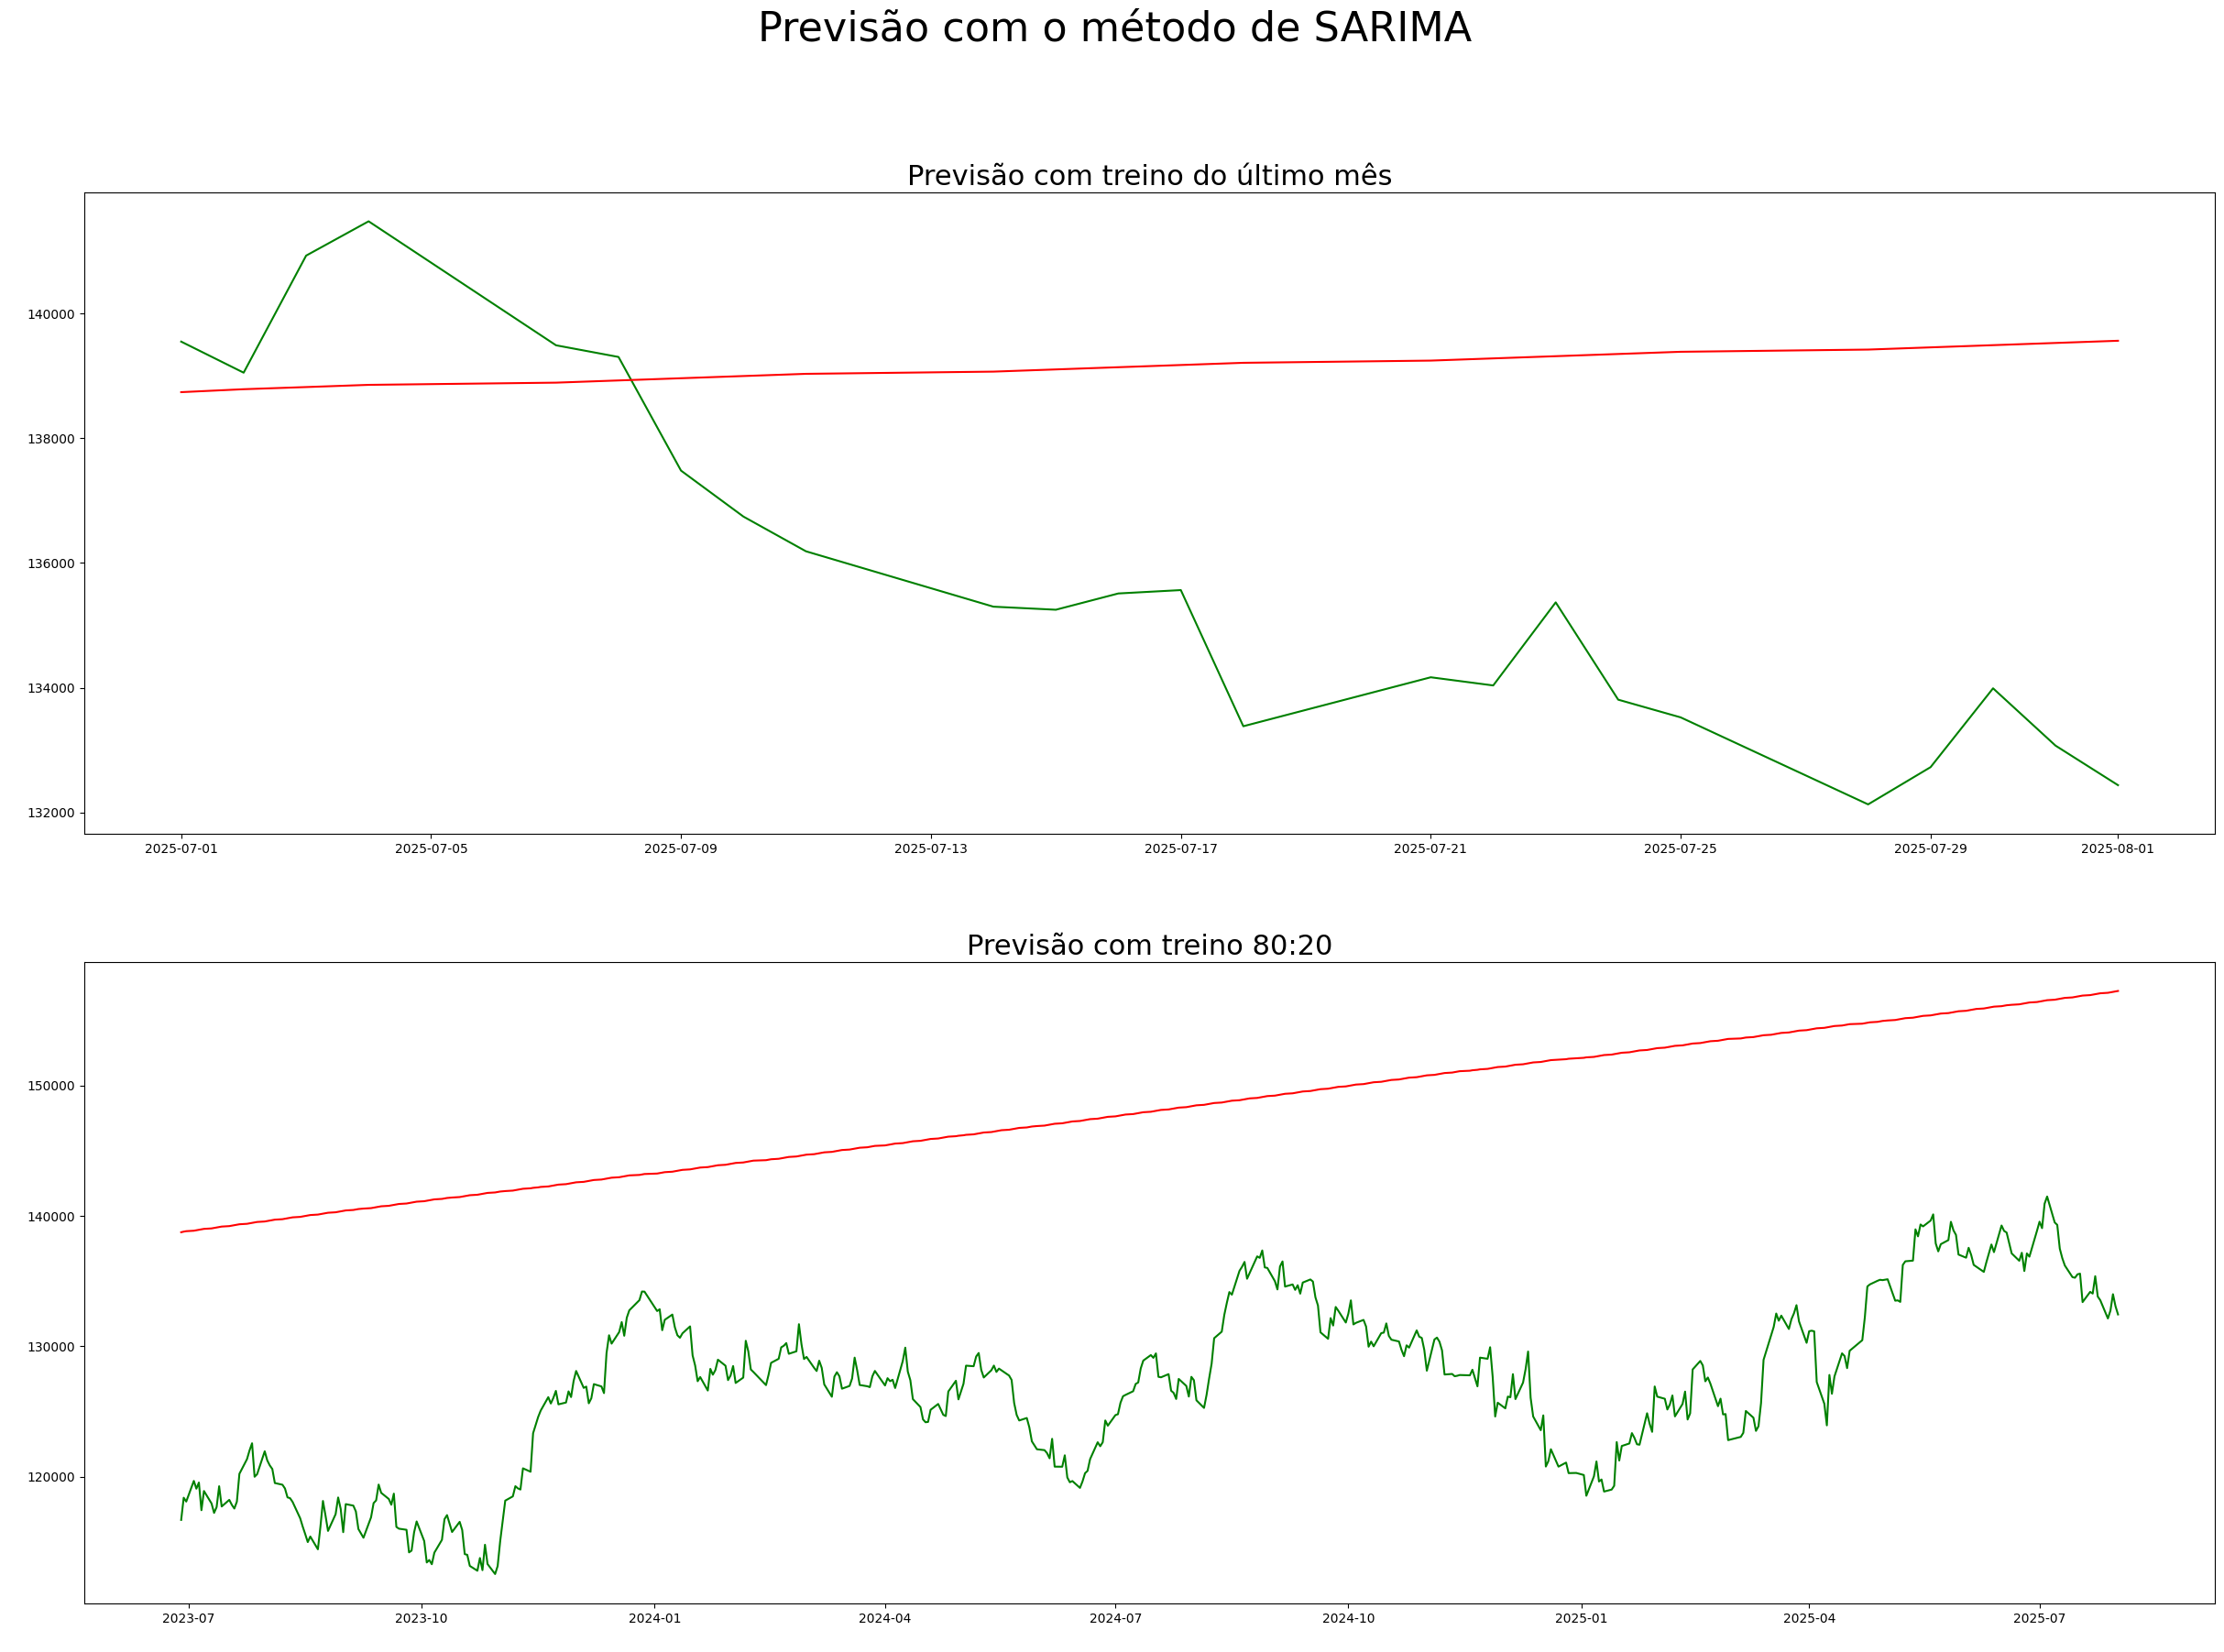

In [70]:
fig, ((ax0, ax1)) = plt.subplots(ncols=1, nrows=2 ,figsize = (30 , 20))
fig.suptitle('Previsão com o método de SARIMA', size = 32)
ax0.set_title('Previsão com treino do último mês', size = 22)
ax0.set_xlabel(' ')
ax0.set_ylabel(' ')
ax1.set_title('Previsão com treino 80:20', size = 22)
ax1.set_xlabel(' ')
ax1.set_ylabel(' ')

sns.lineplot(x = df_teste.index,
             y = df_teste,
             color = 'green',
             ax=ax0)
sns.lineplot(x = forecast_arima.index,
             y = forecast_arima,
             color = 'red',
             ax=ax0)

sns.lineplot(x = df_teste_80.index,
             y = df_teste_80,
             color = 'green',
             ax=ax1)
sns.lineplot(x = forecast_arima_80.index,
             y = forecast_arima_80,
             color = 'red',
             ax=ax1)

### SARIMA

In [71]:
model_sarima = auto_arima(df_treino,
                          start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          d=None,
                          start_P=1, start_Q=1,
                          max_P=5, max_Q=5,
                          m=5,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

print(model_sarima.summary())

# Previsões
forecast_sarima = model_sarima.predict(n_periods=24)
forecast_sarima.index = df_teste.index

print('MAPE:', round(MAPE(df_teste, forecast_sarima)*100,2),"%")
print('wMAPE:', round(MAPE(df_teste, forecast_sarima,sample_weight=df_teste)*100,2),"%")
print('MSE:', round(MSE(df_teste, forecast_sarima),2))

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finit

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=44726.454, Time=1.20 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=44738.723, Time=0.21 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=44723.408, Time=0.46 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=44724.292, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=44738.529, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=44721.729, Time=0.15 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=44723.425, Time=0.36 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=44725.243, Time=0.92 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[5] intercept   : AIC=44722.442, Time=0.28 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=44723.026, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=44722.640, Time=0.19 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=44723.845, Time=1.04 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[5]             : AIC=44721.937, Time=0.22 sec

Best model:  ARIMA(1,1,0)(0,0,0)[5] intercept
Total fit time: 6.030 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2601
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -22357.865
Date:                dom, 03 ago 2025   AIC                          44721.729
Time:                        18:58:14   BIC                          44739.319
Sample:                             0   HQIC                         44728.102
                               - 2601                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     38.0960     27.066      1.407      0.159     -14.953

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [72]:
model_sarima_80 = auto_arima(df_treino_80,
                          start_p=1, start_q=1,
                          max_p=5, max_q=5,
                          d=None,
                          start_P=1, start_Q=1,
                          max_P=5, max_Q=5,
                          m=5,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

print(model_sarima_80.summary())

forecast_sarima_80 = model_sarima_80.predict(n_periods=524)
forecast_sarima_80.index = df_teste_80.index

print('MAPE:', round(MAPE(df_teste_80, forecast_sarima_80)*100,2),"%")
print('wMAPE:', round(MAPE(df_teste_80, forecast_sarima_80,sample_weight=df_teste_80)*100,2),"%")
print('MSE:', round(MSE(df_teste_80, forecast_sarima_80),2))

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finit

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=36246.797, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=36259.282, Time=0.04 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=36244.290, Time=0.32 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=36245.401, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=36258.513, Time=0.04 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=36242.810, Time=0.19 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=36244.325, Time=0.30 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=36245.936, Time=0.50 sec
 ARIMA(2,1,0)(0,0,0)[5] intercept   : AIC=36242.844, Time=0.21 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=36243.762, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=36243.952, Time=0.14 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=36244.024, Time=0.93 sec
 ARIMA(1,1,0)(0,0,0)[5]             : AIC=36242.372, Time=0.08 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[5]             : AIC=36243.788, Time=0.23 sec
 ARIMA(1,1,0)(0,0,1)[5]             : AIC=36243.828, Time=0.15 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[5]             : AIC=36245.179, Time=0.36 sec
 ARIMA(2,1,0)(0,0,0)[5]             : AIC=36242.287, Time=0.10 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[5]             : AIC=36243.884, Time=0.21 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[5]             : AIC=36243.912, Time=0.23 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[5]             : AIC=36245.347, Time=0.74 sec
 ARIMA(3,1,0)(0,0,0)[5]             : AIC=36241.903, Time=0.15 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,0)[5]             : AIC=36243.622, Time=0.35 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[5]             : AIC=36243.641, Time=0.26 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[5]             : AIC=36245.194, Time=0.69 sec
 ARIMA(4,1,0)(0,0,0)[5]             : AIC=36243.609, Time=0.18 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[5]             : AIC=36236.599, Time=0.77 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[5]             : AIC=36237.779, Time=1.43 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,1)[5]             : AIC=36237.862, Time=1.22 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,1)[5]             : AIC=inf, Time=3.43 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[5]             : AIC=36240.462, Time=0.40 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[5]             : AIC=36245.640, Time=0.22 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[5]             : AIC=36234.425, Time=1.42 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,0)[5]             : AIC=36247.561, Time=0.96 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,1)[5]             : AIC=36247.590, Time=0.86 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(1,0,1)[5]             : AIC=36240.257, Time=4.21 sec
 ARIMA(2,1,2)(0,0,0)[5]             : AIC=36245.406, Time=0.18 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[5]             : AIC=36238.295, Time=1.32 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[5]             : AIC=36233.873, Time=2.23 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,0)[5]             : AIC=36242.673, Time=2.93 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,1)[5]             : AIC=36243.096, Time=3.28 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(1,0,1)[5]             : AIC=36242.600, Time=4.61 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[5]             : AIC=36234.391, Time=1.77 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[5]             : AIC=36242.397, Time=1.88 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,0,0)[5]             : AIC=36234.512, Time=1.91 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,0,0)[5]             : AIC=36241.571, Time=0.85 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,0,0)[5]             : AIC=36236.186, Time=1.95 sec


c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[5] intercept   : AIC=36236.341, Time=4.20 sec

Best model:  ARIMA(3,1,3)(0,0,0)[5]          
Total fit time: 50.665 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2101
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -18109.936
Date:                dom, 03 ago 2025   AIC                          36233.873
Time:                        18:59:28   BIC                          36273.421
Sample:                             0   HQIC                         36248.358
                               - 2101                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5878      0.099     -5.925      0.000      -0.78

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Teste de Jarque Bera:
Hipótese nula: Os dados são normalmente distribuídos.
Hipótese alternativa: Os dados não são normalmente distribuídos.
Valor p > nível de significância (geralmente 0,05): Não há evidências suficientes para rejeitar a hipótese nula. A distribuição pode ser considerada normal.

<Axes: title={'center': 'Previsão com treino 80:20'}, xlabel=' ', ylabel=' '>

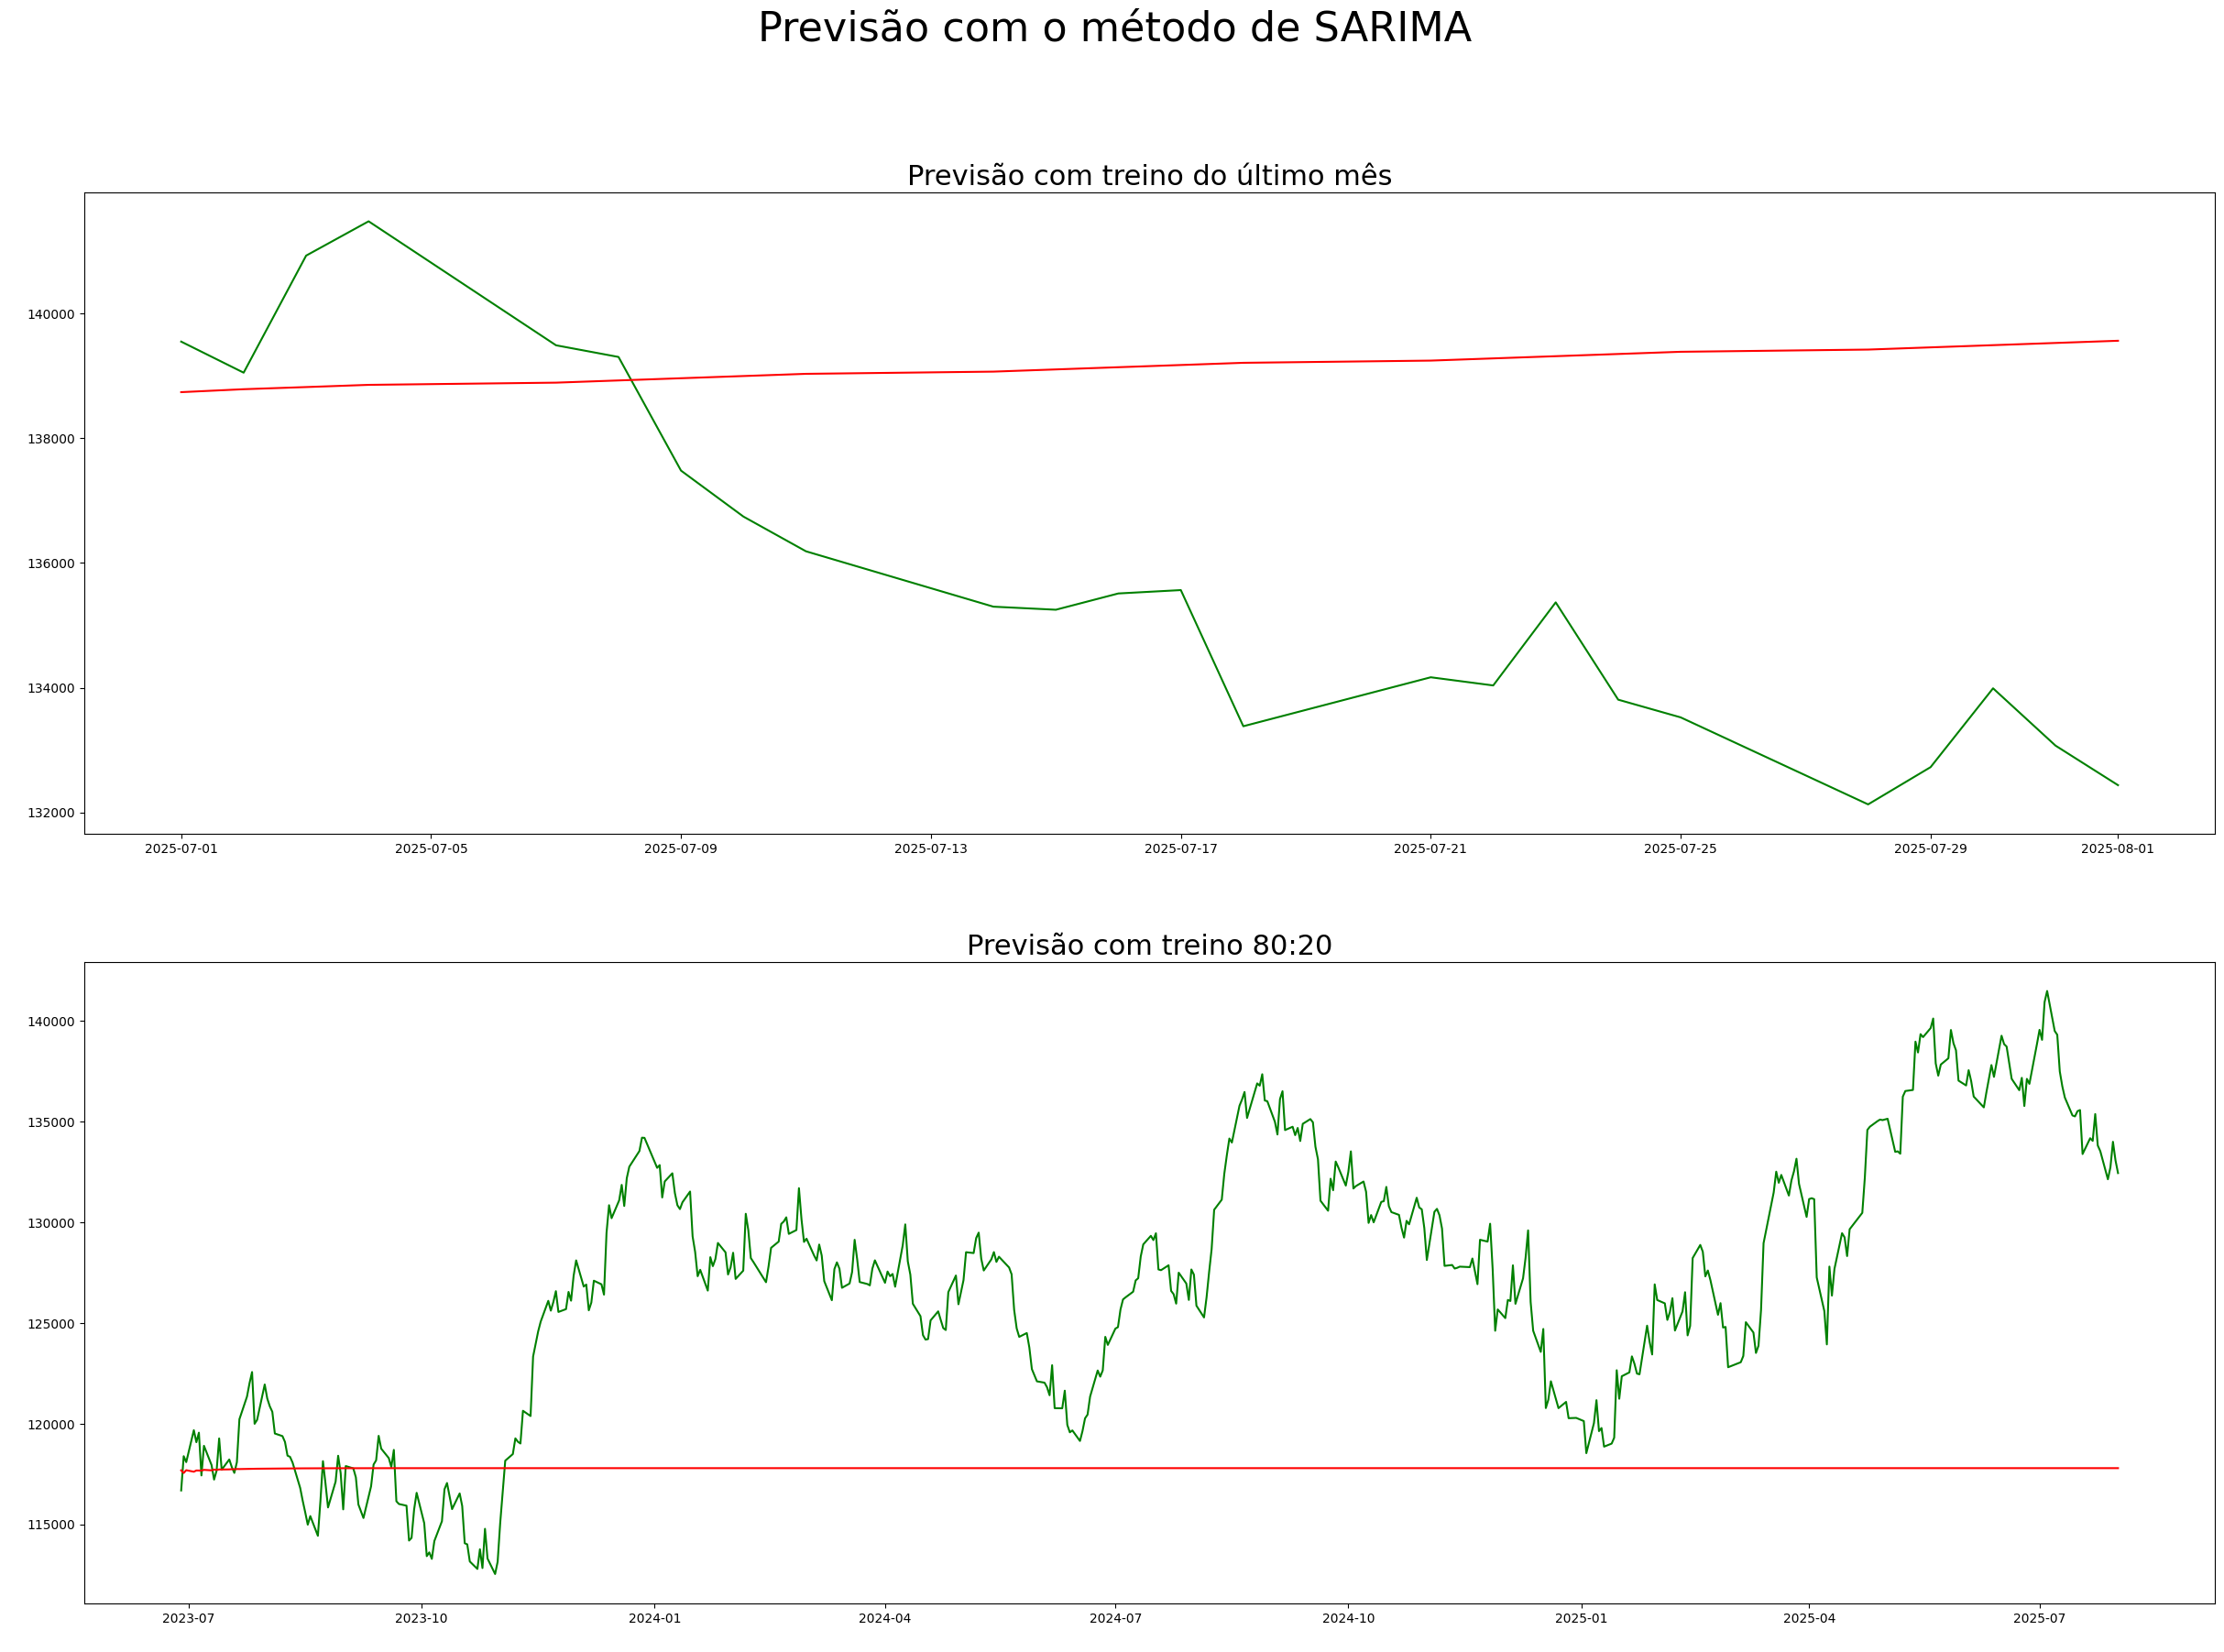

In [64]:
fig, ((ax0, ax1)) = plt.subplots(ncols=1, nrows=2 ,figsize = (30 , 20))
fig.suptitle('Previsão com o método de SARIMA', size = 32)
ax0.set_title('Previsão com treino do último mês', size = 22)
ax0.set_xlabel(' ')
ax0.set_ylabel(' ')
ax1.set_title('Previsão com treino 80:20', size = 22)
ax1.set_xlabel(' ')
ax1.set_ylabel(' ')

sns.lineplot(x = df_teste.index,
             y = df_teste,
             color = 'green',
             ax=ax0)
sns.lineplot(x = forecast_sarima.index,
             y = forecast_sarima,
             color = 'red',
             ax=ax0)

sns.lineplot(x = df_teste_80.index,
             y = df_teste_80,
             color = 'green',
             ax=ax1)
sns.lineplot(x = forecast_sarima_80.index,
             y = forecast_sarima_80,
             color = 'red',
             ax=ax1)

## PREVISÃO COM XGBOOST

treino do modelo

In [200]:
X, y = dados_yf.drop('Close', axis = 1), dados_yf[['Close']]
target = X.select_dtypes(exclude=np.number).columns.tolist()
for col in target:
    X[col] = X[col].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [201]:
params = {"objective": "reg:squarederror", "tree_method": "hist", "device":"cuda"}


n = 500
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

preds = model.predict(dtest_reg)
print('MAPE:', round(MAPE(y_test, preds)*100,2),"%")
print('MSE:', round(MSE(y_test, preds),2))

MAPE: 0.61 %
MSE: 590634.69


In [202]:
params = {"objective": "reg:squarederror", "tree_method": "hist", "device":"cuda"}

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]
n = 500

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10,
   early_stopping_rounds = 20
)

preds = model.predict(dtest_reg)
print('MAPE:', round(MAPE(y_test, preds)*100,2),"%")
print('MSE:', round(MSE(y_test, preds),2))

[0]	train-rmse:19693.52342	validation-rmse:19157.44485
[10]	train-rmse:816.06071	validation-rmse:1010.35335
[20]	train-rmse:450.86288	validation-rmse:774.67436
[30]	train-rmse:403.36690	validation-rmse:769.93632
[40]	train-rmse:370.73863	validation-rmse:761.49095
[50]	train-rmse:348.70958	validation-rmse:760.31231
[60]	train-rmse:319.99749	validation-rmse:755.79638
[70]	train-rmse:291.57051	validation-rmse:755.47601
[80]	train-rmse:271.18056	validation-rmse:755.35393
[85]	train-rmse:256.47804	validation-rmse:754.70403
MAPE: 0.6 %
MSE: 569576.56


crossvalidation

In [161]:
params = {"objective": "reg:squarederror", "tree_method": "hist", "device":"cuda"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=20
)

best_rmse = results['test-rmse-mean'].min()

best_rmse

np.float64(734.4327294747706)

In [ ]:
results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,19707.790996,168.888968,19745.155576,700.177996
1,13891.152940,117.319357,13923.426588,491.735697
2,9798.690689,81.098273,9825.898120,346.814122
3,6921.206562,54.372032,6952.618794,261.167797
4,4900.233481,36.696952,4946.968452,192.539750


Previsão com XGB

In [163]:
X, y = dados_yf.drop('Target', axis = 1), dados_yf[['Target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [210]:
params = {"objective": "binary:logistic", "tree_method": "hist", "device":"cuda", "num_class": 2}
n = 1000

results = xgb.cv(
   params, dtrain_clf,
   num_boost_round=n,
   nfold=5,
   metrics=["mlogloss", "auc", "merror"],
)

XGBoostError: [21:45:32] C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:53: Check failed: info.labels.Size() == preds.Size() (1574 vs. 3148) : Invalid shape of labels.

In [178]:
results['test-auc-mean'].max()

np.float64(0.4983604000822476)

## LIGHTBGM

In [186]:
from catboost import CatBoostClassifier # --> Modelo de ML CatBoost
from lightgbm import LGBMClassifier # --> Modelo de ML LightGBM

In [195]:
modelo_lgbm = LGBMClassifier(random_state=42, verbose = -1)
modelo_lgbm.fit(x_treino_scaled, y_treino)

#previsao_lgbm = modelo_lgbm.predict(x_test_scaled)
previsao_lgbm = modelo_lgbm.predict(pd.DataFrame(x_teste_scaled, columns=x_treino.columns)) # --> Gerado o predict dessa forma para não gerar o Warning

## CATBOOST

In [196]:
# Treinar o modelo e gerar a previsao - CatBoost

modelo_cat = CatBoostClassifier(random_state=42, verbose=0)
modelo_cat.fit(x_treino_scaled, y_treino)
previsao_cat = modelo_cat.predict(x_teste_scaled)

In [207]:
previsao_lgbm

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,

## PREVISÃO COM HOLT-WINTERS


In [74]:
mod_wh_am = ExponentialSmoothing(df_treino, seasonal_periods=5, trend='add', seasonal='mul').fit(optimized=1)
mod_wh_aa = ExponentialSmoothing(df_treino, seasonal_periods=5, trend='add', seasonal='add').fit(optimized=1)
mod_wh_ma = ExponentialSmoothing(df_treino, seasonal_periods=5, trend='mul', seasonal='add').fit(optimized=1)
mod_wh_mm = ExponentialSmoothing(df_treino, seasonal_periods=5, trend='mul', seasonal='mul').fit(optimized=1)

pred_wh_am = mod_wh_am.forecast(24)
predval_wh_am = pd.concat([df_treino, pred_wh_am])
predval_wh_am = pd.DataFrame(predval_wh_am)
predval_wh_am = predval_wh_am.rename(columns={0: 'Previsto - HWam'})

pred_wh_aa = mod_wh_aa.forecast(24)
predval_wh_aa = pd.concat([df_treino, pred_wh_aa])
predval_wh_aa = pd.DataFrame(predval_wh_aa)
predval_wh_aa = predval_wh_aa.rename(columns={0: 'Previsto - HWaa'})

pred_wh_ma = mod_wh_ma.forecast(24)
predval_wh_ma = pd.concat([df_treino, pred_wh_ma])
predval_wh_ma = pd.DataFrame(predval_wh_ma)
predval_wh_ma = predval_wh_ma.rename(columns={0: 'Previsto - HWma'})

pred_wh_mm = mod_wh_mm.forecast(24)
predval_wh_mm = pd.concat([df_treino, pred_wh_mm])
predval_wh_mm = pd.DataFrame(predval_wh_mm)
predval_wh_mm = predval_wh_mm.rename(columns={0: 'Previsto - HWmm'})

df_prev = pd.DataFrame({
    'VALOR PREVISTO - AM': pred_wh_am,
    'VALOR PREVISTO - AA': pred_wh_aa,
    'VALOR PREVISTO - MA': pred_wh_ma,
    'VALOR PREVISTO - MM': pred_wh_mm
})
df_prev.index = df_teste.index

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequenc

In [75]:
print('MAPE - AM:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - AM'])*100,2),"%")
print('wMAPE - AM:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - AM'], sample_weight=df_teste)*100,2),"%")
print('MSE - AM:', round(MSE(df_teste, df_prev['VALOR PREVISTO - AM']),2))
print(' ')
print('MAPE - MM:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - MM'])*100,2),"%")
print('wMAPE - AM:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - MM'], sample_weight=df_teste)*100,2),"%")
print('MSE - MM:', round(MSE(df_teste, df_prev['VALOR PREVISTO - MM']),2))
print(' ')
print('MAPE - MA:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - MA'])*100,2),"%")
print('wMAPE - AM:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - MA'], sample_weight=df_teste)*100,2),"%")
print('MSE - MA:', round(MSE(df_teste, df_prev['VALOR PREVISTO - MA']),2))
print(' ')
print('MAPE - AA:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - AA'])*100,2),"%")
print('wMAPE - AM:', round(MAPE(df_teste, df_prev['VALOR PREVISTO - AA'], sample_weight=df_teste)*100,2),"%")
print('MSE - AA:', round(MSE(df_teste, df_prev['VALOR PREVISTO - AA']),2))

MAPE - AM: 2.9 %
wMAPE - AM: 2.87 %
MSE - AM: 20097722.48
 
MAPE - MM: 2.73 %
wMAPE - AM: 2.7 %
MSE - MM: 17480590.96
 
MAPE - MA: 2.9 %
wMAPE - AM: 2.87 %
MSE - MA: 20092542.11
 
MAPE - AA: 2.92 %
wMAPE - AM: 2.89 %
MSE - AA: 20295758.38


In [76]:
mod_wh_am = ExponentialSmoothing(df_treino_80, seasonal_periods=5, trend='add', seasonal='mul').fit(optimized=1)
mod_wh_aa = ExponentialSmoothing(df_treino_80, seasonal_periods=5, trend='add', seasonal='add').fit(optimized=1)
mod_wh_ma = ExponentialSmoothing(df_treino_80, seasonal_periods=5, trend='mul', seasonal='add').fit(optimized=1)
mod_wh_mm = ExponentialSmoothing(df_treino_80, seasonal_periods=5, trend='mul', seasonal='mul').fit(optimized=1)

pred_wh_am = mod_wh_am.forecast(524)
predval_wh_am = pd.concat([df_treino_80, pred_wh_am])
predval_wh_am = pd.DataFrame(predval_wh_am)
predval_wh_am = predval_wh_am.rename(columns={0: 'Previsto - HWam'})

pred_wh_aa = mod_wh_aa.forecast(524)
predval_wh_aa = pd.concat([df_treino_80, pred_wh_aa])
predval_wh_aa = pd.DataFrame(predval_wh_aa)
predval_wh_aa = predval_wh_aa.rename(columns={0: 'Previsto - HWaa'})

pred_wh_ma = mod_wh_ma.forecast(524)
predval_wh_ma = pd.concat([df_treino_80, pred_wh_ma])
predval_wh_ma = pd.DataFrame(predval_wh_ma)
predval_wh_ma = predval_wh_ma.rename(columns={0: 'Previsto - HWma'})

pred_wh_mm = mod_wh_mm.forecast(524)
predval_wh_mm = pd.concat([df_treino_80, pred_wh_mm])
predval_wh_mm = pd.DataFrame(predval_wh_mm)
predval_wh_mm = predval_wh_mm.rename(columns={0: 'Previsto - HWmm'})

df_prev_80 = pd.DataFrame({
    'VALOR PREVISTO - AM': pred_wh_am,
    'VALOR PREVISTO - AA': pred_wh_aa,
    'VALOR PREVISTO - MA': pred_wh_ma,
    'VALOR PREVISTO - MM': pred_wh_mm
})
df_prev_80.index = df_teste_80.index

c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cayou\Desktop\demanda johnzao\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\

In [77]:
print('MAPE - AM:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - AM'])*100,2),"%")
print('wMAPE - AM:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - AM'], sample_weight=df_teste_80)*100,2),"%")
print('MSE - AM:', round(MSE(df_teste_80, df_prev_80['VALOR PREVISTO - AM']),2))
print(' ')
print('MAPE - MM:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - MM'])*100,2),"%")
print('wMAPE - AM:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - MM'], sample_weight=df_teste_80)*100,2),"%")
print('MSE - MM:', round(MSE(df_teste_80, df_prev_80['VALOR PREVISTO - MM']),2))
print(' ')
print('MAPE - MA:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - MA'])*100,2),"%")
print('wMAPE - AM:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - MA'], sample_weight=df_teste_80)*100,2),"%")
print('MSE - MA:', round(MSE(df_teste_80, df_prev_80['VALOR PREVISTO - MA']),2))
print(' ')
print('MAPE - AA:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - AA'])*100,2),"%")
print('wMAPE - AM:', round(MAPE(df_teste_80, df_prev_80['VALOR PREVISTO - AA'], sample_weight=df_teste_80)*100,2),"%")
print('MSE - AA:', round(MSE(df_teste_80, df_prev_80['VALOR PREVISTO - AA']),2))

MAPE - AM: 3.75 %
wMAPE - AM: 3.81 %
MSE - AM: 32911942.02
 
MAPE - MM: 3.32 %
wMAPE - AM: 3.33 %
MSE - MM: 25886568.19
 
MAPE - MA: 4.49 %
wMAPE - AM: 4.6 %
MSE - MA: 48824157.56
 
MAPE - AA: 3.22 %
wMAPE - AM: 3.2 %
MSE - AA: 25595948.41


<Axes: title={'center': 'Previsão com treino 80:20'}, xlabel=' ', ylabel=' '>

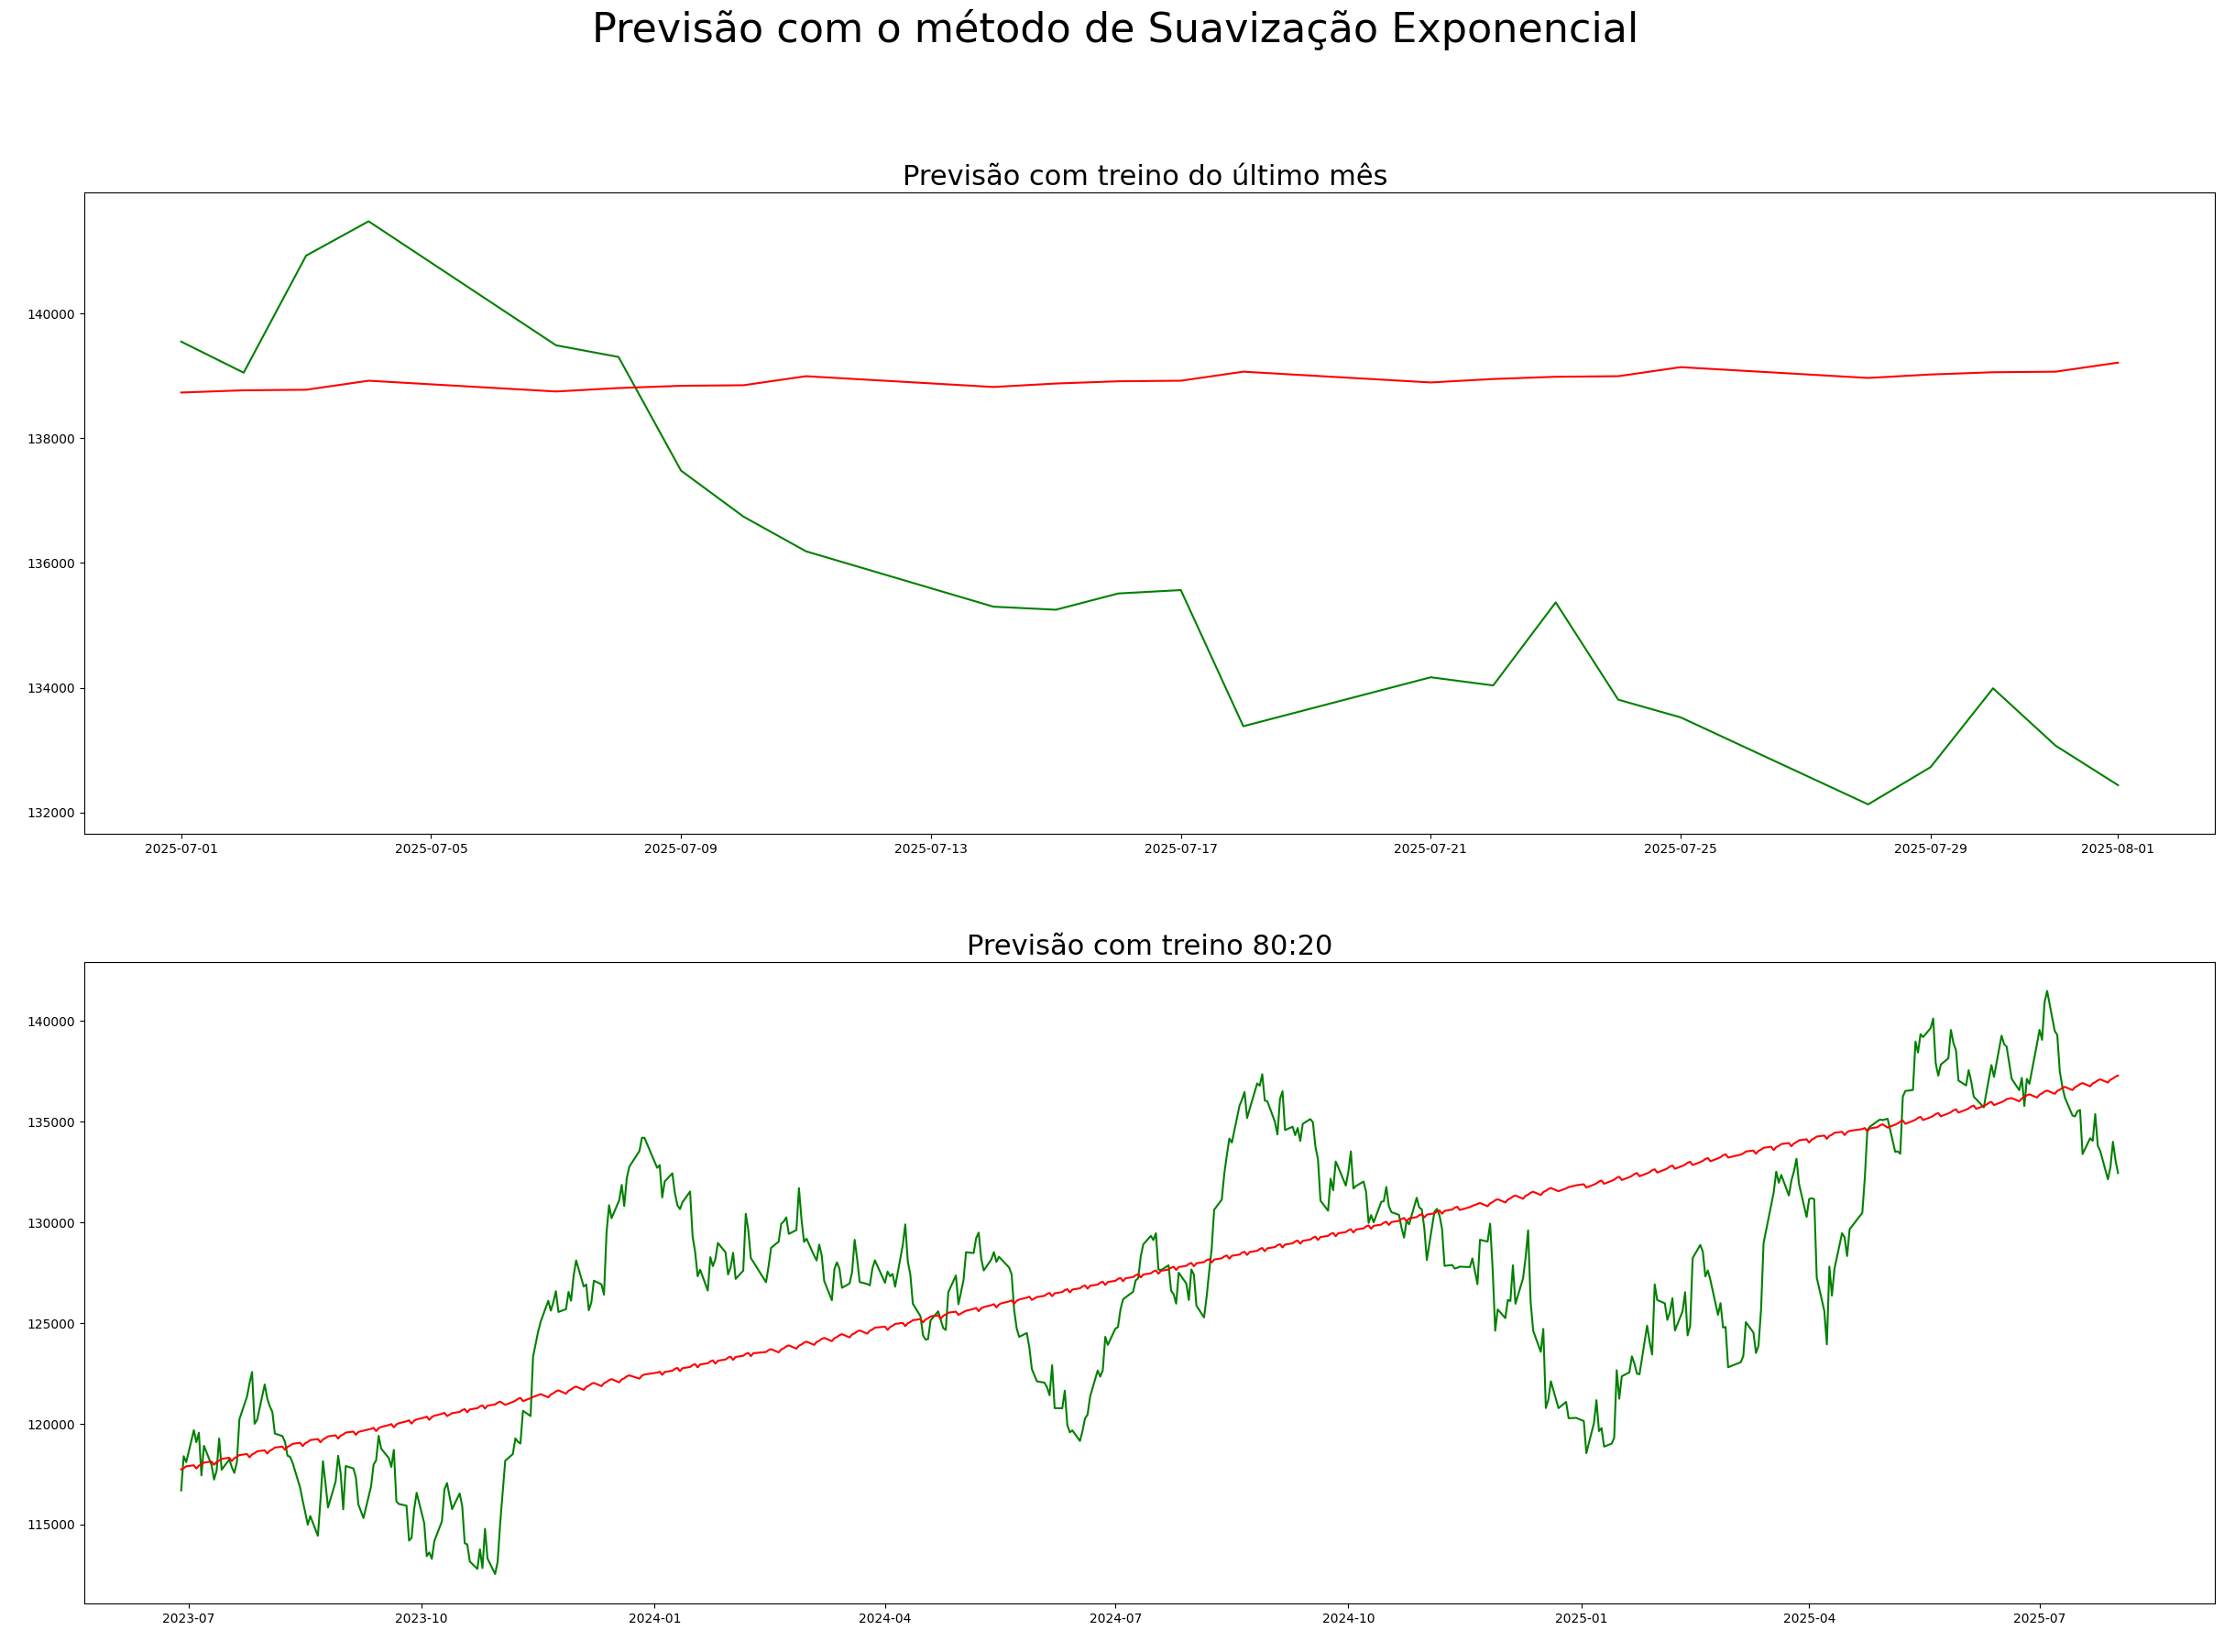

In [78]:
fig, ((ax0, ax1)) = plt.subplots(ncols=1, nrows=2 ,figsize = (30 , 20))
fig.suptitle('Previsão com o método de Suavização Exponencial', size = 32)
ax0.set_title('Previsão com treino do último mês ', size = 22)
ax0.set_xlabel(' ')
ax0.set_ylabel(' ')
ax1.set_title('Previsão com treino 80:20', size = 22)
ax1.set_xlabel(' ')
ax1.set_ylabel(' ')

sns.lineplot(x = df_teste.index,
             y = df_teste,
             color = 'green',
             ax=ax0)
sns.lineplot(x = df_prev.index,
             y = df_prev['VALOR PREVISTO - MM'],
             color = 'red',
             ax=ax0)

sns.lineplot(x = df_teste_80.index,
             y = df_teste_80,
             color = 'green',
             ax=ax1)
sns.lineplot(x = df_prev_80.index,
             y = df_prev_80['VALOR PREVISTO - AA'],
             color = 'red',
             ax=ax1)


# AVALIAÇÃO DE MODELOS

In [ ]:
modelos_avaliados = {
    "XGBoost":             {"modelo": modelo_lgbm, "previsoes": previsao_lgbm},
    "LightGBM":            {"modelo": modelo_lgbm, "previsoes": previsao_lgbm},
    "CatBoost":            {"modelo": modelo_cat, "previsoes": previsao_cat}
}

# Criar um data frame com os resultados
performance = pd.DataFrame(
    columns=["Modelo", "Acurácia", "Precisão", "Recall", "F1-Score"]
)

for nome, dados in modelos_avaliados.items():
    report = classification_report(y_teste, dados["previsoes"], output_dict=True, zero_division=0)
    
    performance.loc[performance.shape[0]] = {
        "Modelo": nome,
        "Acurácia": report["accuracy"],
        "Precisão": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }

performance.set_index("Modelo", inplace=True)
performance_formatada = performance.sort_values(by="Acurácia", ascending=False)
performance_formatada = performance_formatada.map(lambda x: f"{(100 * x):.2f} %")

display(performance_formatada)

,Acurácia,Precisão,Recall,F1-Score
Modelo,,,,
CatBoost,51.72 %,51.71 %,51.72 %,51.71 %
LightGBM,50.76 %,50.79 %,50.76 %,50.67 %
